<div style="float: right; width: 70%; height: 150px;">
  <div style="position: relative; top: 20%;padding-right:20%;">
  <div style="font-size:280%;font-weight: bold;padding-top: 20px;"> Exercise</div>
  <div style="font-size:180%;font-weight: bold;padding-top: 20px;color: rgba(0 , 0 , 0 , 0.5);"> Normal modes of the Earth</div>
  </div>
</div>


This script will download a seismogram from IRIS for a large earthquake and look at
its Fourier spectrum to study the free oscillations of the Earth.<br>
It consists of 3 main parts:
1. Data download     - downloads the seismogram from IRIS
2. Data processing   - detrending, filtering, instrument correction, interpolation
3. Amplitude spectra - computes the amplitude spectra of the trace and visualizes it

**Questions**:<br> 
**What happens to the spectrum, if you change the seismogram length?**<br>
**How does the data processing affect normal mode frequency measurements?**<br> 


For comparison and as a reference, see:<br>
   Park et al., 2005,<br>
   *Earth’s Free Oscillations Excited by the 26 December 2004 Sumatra-Andaman Earthquake*,<br>
   Science, Vol. 308<br>
   https://www.science.org/doi/10.1126/science.1112305


for more notebooks in seismology, see:<br>
https://krischer.github.io/seismo_live_build/tree/index.html


## 0. Setup

Note: this python script requires extra packages for
    - matplotlib (version 2.1.2) : > pip install -U matplotlib
    - numpy      (version 1.14.0): > pip install -U numpy
    - obspy      (version 1.1.0) : > pip install -U obspy

In [4]:
from __future__ import print_function
import os,sys

# for fixed plots
%matplotlib inline
# for interactive plots
#%matplotlib notebook

import matplotlib as mpl
print("matplotlib version: ",mpl.__version__)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 20, 5
plt.rcParams['lines.linewidth'] = 0.5

## numpy
import numpy as np
print("numpy version: ",np.__version__)

# do not show scipy warnings
import warnings
warnings.filterwarnings('ignore')

matplotlib version:  3.1.3
numpy version:  1.18.1


uses obspy<br>
http://docs.obspy.org<br>
a python framework for seismology


In [5]:
import obspy
print("obspy version: ",obspy.__version__)

obspy version:  1.1.1


### Table - mode frequencies

PREM frequency table:<br> 
https://igppweb.ucsd.edu/~guy/sio227b/mode_lect1.pdf

also, for mode comparison see:<br> 
http://www.ipgp.fr/~jpm/PUBLICATIONS/JPCS-normalmodes.pdf

In [6]:
modes = {
(r'$_0 S_2$',   309.28e-6, 'r'),
(r'$_0 T_2$',   379.17e-6, 'b'),
(r'$_2 S_1$',   403.96e-6, 'r'),
(r'$_0 S_3$',   468.56e-6, 'r'),
(r'$_0 T_3$',   586.16e-6, 'b'),
(r'$_0 S_4$',   647.07e-6, 'r'),
(r'$_0 S_0$',   814.31e-6, 'r'),
(r'$_0 S_5$',   840.42e-6, 'r'),
(r'$_0 T_5$',   928.24e-6, 'b'),
(r'$_2 S_2$',   937.85e-6, 'r'),
(r'$_1 S_3$',   939.83e-6, 'r'),
(r'$_3 S_1$',   943.95e-6, 'r'),
(r'$_0 S_6$',  1038.21e-6, 'r'),
(r'$_0 T_6$',  1078.83e-6, 'b'),
(r'$_3 S_2$',  1106.21e-6, 'r')
}

# additional interesting frequencies
f0 = 1./(24. * 60. * 60.) # 1 day period
modes.update([
#('0.2mHz',  0.2e-3, 'gray'),
#('1mHz',      1e-3, 'gray'),
('tidal 24h',   f0, 'gray'),
('tidal 12h', 2*f0, 'gray')
#('tidal 8h' , 3*f0, 'gray'),
#('tidal 6h',  4*f0, 'gray')
])




## 1. Data download

Specify the event time.<br>

Sumatra earthquake: (Magnitude Mw ~ 9.1)<br>
December 26, 2004, UTC 00:58:52 -> 2004-12-26T00:58:52.0 


In [4]:
from obspy.clients.fdsn import Client

event_time = obspy.UTCDateTime("2004-12-26T00:58:52.0")

# client
# data centers: FDSN, IRIS, ORFEUS, IPGP, ETH, GFZ, RESIF, GEONET, USGS, ..
c = Client("IRIS")

# seismograms
print("getting waveform...")

# Stations
# station: Canberra, Australia - station name: CAN, network name: G, channel: LHZ
net = "G"
sta = "CAN"
cha = "LHZ"

# time window
t1 = event_time - 10 * 60 * 60             # 10 h earlier
t2 = event_time + 5 * 24 * 60 * 60         # 5 days after

# dowloads seismogram as a stream
st = c.get_waveforms(network=net, station=sta, location="*", channel=cha,
                     starttime=t1,endtime=t2, attach_response=True)
print(st)
print("")


getting waveform...
1 Trace(s) in Stream:
G.CAN..LHZ | 2004-12-25T14:58:52.661800Z - 2004-12-31T00:58:50.661800Z | 1.0 Hz, 467999 samples



## 2. Data processing

Detrending, tapering

In [5]:
print("processing waveform data...")

# working copy for processing
st_w = st.copy()

# detrending & tapering
st_w.detrend("linear")
st_w.detrend("demean")
st_w.taper(max_percentage=0.05)

# trace statistics
tr = st[0]
#print(tr.stats)
npts = tr.stats.npts      # number of samples
dt = tr.stats.delta       # time step
duration = npts * dt

freq_Ny = 1.0/(2.0 * dt)  # Nyquist frequency
freq_min = 1./duration    # minimal possible frequency for length of trace

print("trace:")
print("  duration = ",duration,"s"," = ",duration/60.,"min"," = ",duration/60./60.,"h")
print("  Nyquist frequency = ",freq_Ny)
print("  minimum frequency = ",freq_min)
print("")
# lowest normal mode frequency
f_min_mode = 309.28e-6  # mode 0_S_2  -> period ~ 53.9 min
print("  maximum normal mode period = ",1./f_min_mode/60.,"(min) - mode 0_S_2")
print("")


processing waveform data...
trace:
  duration =  467999.0 s  =  7799.98333333 min  =  129.999722222 h
  Nyquist frequency =  0.5
  minimum frequency =  2.13675670247e-06

  maximum normal mode period =  53.888601483 (min) - mode 0_S_2



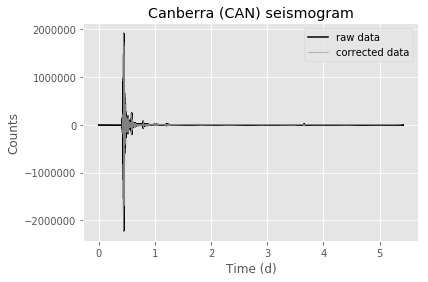

In [6]:
# plotting trace
t_s = np.arange(0, duration, dt)
t_d = np.linspace(0,duration,npts) / (24*3600)  # time axis for plotting (in day)
plt.title("Canberra (CAN) seismogram")
plt.plot(t_d, st[0].data, color='black', linewidth=1.5,label="raw data")
plt.plot(t_d, st_w[0].data, color='gray',label="corrected data")
plt.legend()
plt.xlabel("Time (d)")
plt.ylabel("Counts")
plt.show()


Converts response to displacement:

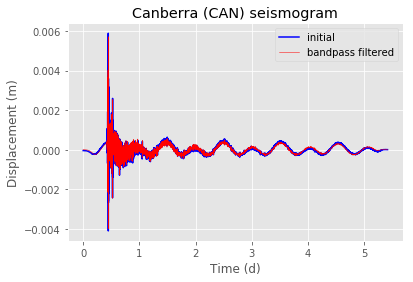

In [7]:
# instrument response removal
# (unstable procedure)
# tidal 24h = 1./(24*60*60) = 1.157 e-5
f1 = 1.0/(1.8 * 24*60.*60.)  # 400.0  - low-frequency taper range
f2 = 1.0/(1.5 * 24*60.*60.)  # 200.0
f3 = 2.0        #high-frequency taper range
f4 = 4.0

#st.remove_response(inventory=inv,output="DISP")[0]
st_w.remove_response(output="DISP",
                       # Make sure to not touch the frequency band of interest
                       pre_filt=(f1,f2,f3,f4))

# trace in displacement
tr1 = st_w[0].copy()

# band-pass filtering
f1 = 1.0/(1.1 * 24*60.*60.) # 200.0 min
f2 = 1.0/15.0  # max
st_w.filter("bandpass", freqmin=f1, freqmax=f2, corners=6, zerophase=True)

# taper again
st_w.taper(max_percentage=0.05) # default: uses Hann window taper

# plotting trace
plt.title("Canberra (CAN) seismogram")
plt.plot(t_d, tr1.data, color='blue', linewidth=1.5,label="initial")
plt.plot(t_d, st_w[0].data, color='red',label="bandpass filtered")
plt.legend()
plt.xlabel("Time (d)")
plt.ylabel("Displacement (m)")
plt.show()


(Optional) Interpolates trace:

In [8]:
# Force continuity - fixed in latest ObsPy master.
#for tr in st_obs:
#    tr.data = np.require(tr.data, requirements=["C_CONTIGUOUS"])

# resampling
#st.interpolate( sampling_rate=20.0,
#                    # sinc based reconstruction filter.
#                    method="lanczos", a=12,
#                    starttime=st[0].stats.starttime,
#                    npts=st[0].stats.npts)
# resampling with a sampling rate of 2s
# used to lower the number of trace points and speed up the following FFT
st_w.interpolate( sampling_rate=0.5,method="lanczos", a=12)


1 Trace(s) in Stream:
G.CAN..LHZ | 2004-12-25T14:58:52.661800Z - 2004-12-31T00:58:50.661800Z | 0.5 Hz, 234000 samples

## Amplitude spectrum

In [9]:
# vertical component
# will (mainly) show spheroidal modes
#tr = st.select(component="Z").copy() # in case stream has more components (E,N,Z)

tr = st[0].copy()     # raw
tr1 = st_w[0].copy()  # corrected

# Frequency domain
FT = np.fft.rfft(tr.data)
FT1 = np.fft.rfft(tr1.data)

# amplitude spectrum
FT = np.abs(FT)
FT1 = np.abs(FT1)


plotting amplitude spectra...


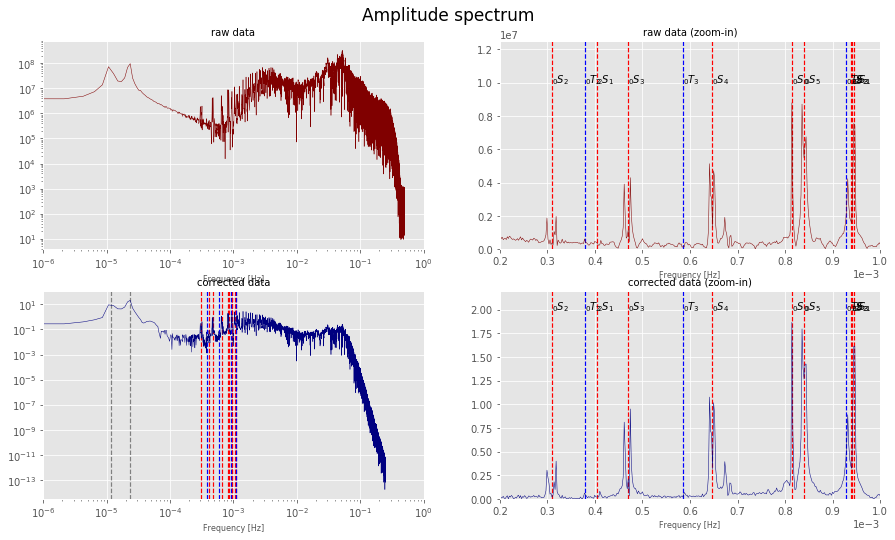

In [10]:
print("plotting amplitude spectra...")

# Frequency axis for plotting
freqs = np.fft.rfftfreq(tr.stats.npts, d=tr.stats.delta)
freqs1 = np.fft.rfftfreq(tr1.stats.npts, d=tr1.stats.delta)

# Figure
# log-log overall plots and linear zoom-in plots
#
# limits overall
xlim1_min = 1.e-6
xlim1_max = 1.0
# limits zoom-in
xlim2_min = 0.2e-3
xlim2_max = 1.e-3

# figure size
plt.rcParams['figure.figsize'] = 15, 8

# figure layout with 2 columns and 2 rows subplots(22*)
#    _________________
#    | 221    | 222   |
#    |________|_______|
#    | 223    | 224   |
#    |________|_______|
#
# raw data
plt.subplot(221)
plt.title("raw data",size=10)
plt.loglog(freqs, FT,color='maroon')
plt.xlim(1e-6, 1)
plt.xlabel("Frequency [Hz]",size=8)
# zoom-in
plt.subplot(222)
plt.title("raw data (zoom-in)",size=10)
for m in modes:
    if m[1] >= xlim2_min and m[1] <= xlim2_max:
        plt.axvline(m[1], color=m[2], label=m[0], lw=1.2, linestyle='--')
        plt.text(m[1], 1.e7, m[0])
plt.plot(freqs, FT,color='maroon')
#plt.legend()
plt.xlim(0.2e-3, 1.0e-3)
plt.ylim(0, 1.25e7)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
plt.xlabel("Frequency [Hz]",size=8)

# displacement data
plt.subplot(223)
plt.title("corrected data",size=10)
for m in modes:
    plt.axvline(m[1], color=m[2], label=m[0], lw=1.2, linestyle='--')
    #plt.text(m[1], 1.0, m[0])
plt.loglog(freqs1, FT1,color='navy')
plt.xlim(1e-6, 1)
plt.xlabel("Frequency [Hz]",size=8)
# zoom-in
plt.subplot(224)
plt.title("corrected data (zoom-in)",size=10)
for m in modes:
    if m[1] >= xlim2_min and m[1] <= xlim2_max:
        plt.axvline(m[1], color=m[2], label=m[0], lw=1.2, linestyle='--')
        plt.text(m[1], 2.0, m[0])
        #plt.annotate(m[0], xy=(m[1], 0), xytext=(m[1], 2.0),
        #             arrowprops=dict(facecolor=m[2], shrink=0.05, width=1.0, frac=0.0))
plt.plot(freqs1, FT1,color='navy')
#plt.legend()
plt.xlim(0.2e-3, 1.0e-3)
plt.ylim(0, 2.2)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
plt.xlabel("Frequency [Hz]",size=8)

# title
plt.suptitle("Amplitude spectrum", size=17)
plt.subplots_adjust(top=0.92)
plt.show()


In [11]:
print("done")

done
